## Aim of the project is to train a CNN model for fine grained classification on CUB Dataset. I have used pre-trained model for classification which is followed by downstream classification. There are various methods to fine tune the model and improve accuracy upon it's pretrained version. Some of the methods implemented are:
### 1) Data Augmentation
### 2) Learning Rate Scheduling(Used CosineAnnealingLR)
### 3) Dropout
### 4) Model Architectures
### 5) Ensemble Methods

In [2]:
pip install efficientnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [41]:
# importing necessary packages
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import torch, os
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
from torchsummary import summary

In [4]:
BATCH_SIZE = 64
NUM_WORKERS = 4
SPLIT_RATIO = 0.9
RANDOM_SEED = 123
CLASS_NUM = 200
ROOT = r'../input/cub2002011/CUB_200_2011'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation 

This code defines a class CUB for handling a dataset. It loads image and label data from files, splits the dataset into train, test, and optionally validation sets, and provides functionality to retrieve images and labels. It also includes a method to convert greyscale images to RGB mode.

In [5]:
# Train-test split
class CUB():
    def __init__(self, root, dataset_type='train', train_ratio=1, valid_seed=123, transform=None, target_transform=None):
        """
        Initializes CUB dataset.

        Args:
            root (str): Root directory of the dataset.
            dataset_type (str, optional): Type of dataset - 'train', 'test', or 'valid'. Defaults to 'train'.
            train_ratio (float, optional): Ratio of training data to total data. Defaults to 1.
            valid_seed (int, optional): Seed for randomization of validation set. Defaults to 123.
            transform (callable, optional): Optional transform to be applied to the images. Defaults to None.
            target_transform (callable, optional): Optional transform to be applied to the labels. Defaults to None.
        """
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        # Load dataframes
        df_img = pd.read_csv(os.path.join(root, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
        df_label = pd.read_csv(os.path.join(root, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
        df_split = pd.read_csv(os.path.join(root, 'train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)
        df = pd.concat([df_img, df_label, df_split], axis=1)
        
        # Relabel
        df['Label'] = df['Label'] - 1

        # Split data
        if dataset_type == 'test':
            df = df[df['Train'] == 0]
        elif dataset_type == 'train' or dataset_type == 'valid':
            df = df[df['Train'] == 1]
            # Random split train, valid
            if train_ratio != 1:
                np.random.seed(valid_seed)
                indices = list(range(len(df)))
                np.random.shuffle(indices)
                split_idx = int(len(indices) * train_ratio) + 1
            elif dataset_type == 'valid':
                raise ValueError('train_ratio should be less than 1!')
            if dataset_type == 'train':
                df = df.iloc[indices[:split_idx]]
            else:       # dataset_type == 'valid'
                df = df.iloc[indices[split_idx:]]
        else:
            raise ValueError('Unsupported dataset_type!')

        # Extract image names and labels
        self.img_name_list = df['Image'].tolist()
        self.label_list = df['Label'].tolist()
        
        # Convert greyscale images to RGB mode
        self._convert2rgb()

    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.label_list)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset by index.

        Args:
            idx (int): Index of the item.

        Returns:
            tuple: Tuple containing the image and its corresponding label.
        """
        img_path = os.path.join(self.root, 'images', self.img_name_list[idx])
        image = Image.open(img_path)
        target = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

    def _convert2rgb(self):
        """
        Converts greyscale images to RGB mode.
        """
        for i, img_name in enumerate(self.img_name_list):
            img_path = os.path.join(self.root, 'images', img_name)
            image = Image.open(img_path)
            color_mode = image.mode
            if color_mode != 'RGB':
                # image = image.convert('RGB')
                # image.save(img_path.replace('.jpg', '_rgb.jpg'))
                self.img_name_list[i] = img_name.replace('.jpg', '_rgb.jpg')


In [7]:
# # train test split 
# class CUB():
#     def __init__(self, root, dataset_type='train', train_ratio=1, valid_seed=123, transform=None, target_transform=None):
#         self.root = root
#         self.transform = transform
#         self.target_transform = target_transform

#         df_img = pd.read_csv(os.path.join(root, 'images.txt'), sep=' ', header=None, names=['ID', 'Image'], index_col=0)
#         df_label = pd.read_csv(os.path.join(root, 'image_class_labels.txt'), sep=' ', header=None, names=['ID', 'Label'], index_col=0)
#         df_split = pd.read_csv(os.path.join(root, 'train_test_split.txt'), sep=' ', header=None, names=['ID', 'Train'], index_col=0)
#         df = pd.concat([df_img, df_label, df_split], axis=1)
#         # relabel
#         df['Label'] = df['Label'] - 1

#         # split data
#         if dataset_type == 'test':
#             df = df[df['Train'] == 0]
#         elif dataset_type == 'train' or dataset_type == 'valid':
#             df = df[df['Train'] == 1]
#             # random split train, valid
#             if train_ratio != 1:
#                 np.random.seed(valid_seed)
#                 indices = list(range(len(df)))
#                 np.random.shuffle(indices)
#                 split_idx = int(len(indices) * train_ratio) + 1
#             elif dataset_type == 'valid':
#                 raise ValueError('train_ratio should be less than 1!')
#             if dataset_type == 'train':
#                 df = df.iloc[indices[:split_idx]]
#             else:       # dataset_type == 'valid'
#                 df = df.iloc[indices[split_idx:]]
#         else:
#             raise ValueError('Unsupported dataset_type!')
#         self.img_name_list = df['Image'].tolist()
#         self.label_list = df['Label'].tolist()
#         # Convert greyscale images to RGB mode
#         self._convert2rgb()

#     def __len__(self):
#         return len(self.label_list)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root, 'images', self.img_name_list[idx])
#         image = Image.open(img_path)
#         target = self.label_list[idx]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             target = self.target_transform(target)
#         return image, target

#     def _convert2rgb(self):
#         for i, img_name in enumerate(self.img_name_list):
#             img_path = os.path.join(self.root, 'images', img_name)
#             image = Image.open(img_path)
#             color_mode = image.mode
#             if color_mode != 'RGB':
#                 # image = image.convert('RGB')
#                 # image.save(img_path.replace('.jpg', '_rgb.jpg'))
#                 self.img_name_list[i] = img_name.replace('.jpg', '_rgb.jpg')

## Data Transformations/Augmentation

In [6]:
# For training data
trans_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(30),  # Randomly rotate the image by a maximum of 30 degrees
    transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),  # Randomly resize and crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# For testing/validation data
trans_test = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.CenterCrop(224),  # Center crop the image to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [8]:
# trans_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(30),
#     transforms.RandomResizedCrop(224, scale=(0.7, 1), ratio=(3/4, 4/3)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# trans_test = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [8]:
# create dataset
train_data = CUB(ROOT, 'train', SPLIT_RATIO, RANDOM_SEED, transform=trans_train)
valid_data = CUB(ROOT, 'valid', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)
test_data = CUB(ROOT, 'test', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)
print("Train: {}".format(len(train_data)))
print("Test: {}".format(len(test_data)))

Train: 5395
Test: 5794


## Visualize image samples

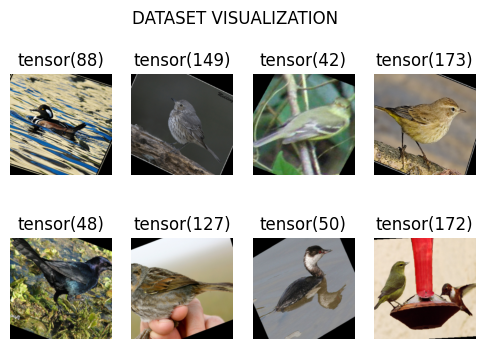

In [9]:
def imshow(image, label, ax=None, normalize=True):
    """Show a single image along with its label on an axis.

    Args:
        image (Tensor): Image tensor.
        label (str): Label of the image.
        ax (Axes, optional): Matplotlib axis to display the image. If None, a new figure and axis will be created.
        normalize (bool, optional): Whether to normalize the image. Defaults to True.

    Returns:
        Axes: Matplotlib axis containing the displayed image.
    """
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(label)

    return ax


def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
    """Show multiple samples.

    Args:
        images (list): List of image tensors.
        labels (list): List of labels corresponding to images.
        nrows (int, optional): Number of rows in the grid. Defaults to 2.
        ncols (int, optional): Number of columns in the grid. Defaults to 3.
        title (str, optional): Title of the figure. Defaults to None.
        normalize (bool, optional): Whether the images are normalized. Defaults to True.
    """
    fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

    # .flat: to map samples to multi-dimensional axes
    for (ax, image, label) in zip(axes.flat, images, labels):
        ax = imshow(image, label, ax, normalize)

    fig.suptitle(title)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()
    
    
# show samples
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
images, labels = next(iter(train_loader))
show_samples(images[0:8], labels[0:8], 2, 4, 'DATASET VISUALIZATION')

In [10]:
# def imshow(image, label, ax=None, normalize=True):
#     """show single along with label on an ax"""
    
#     if ax is None:
#         fig, ax = plt.subplots()
#     image = image.numpy().transpose((1, 2, 0))

#     if normalize:
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         image = std * image + mean
#         image = np.clip(image, 0, 1)

#     ax.imshow(image)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.tick_params(axis='both', length=0)
#     ax.set_xticklabels('')
#     ax.set_yticklabels('')
#     ax.set_title(label)

#     return ax


# def show_samples(images, labels, nrows=2, ncols=3, title=None, normalize=True):
#     """ show multiple samples

#     args:
#         nrows (int, optional): number of row
#         ncols (int, optional): number of column
#         title (str, optional): title.
#         normalize (bool, optional): whether the images are normalized
#     """
#     fig, axes = plt.subplots(nrows, ncols, facecolor='#ffffff', dpi=100)

#     # .flat: to map samples to multi-dimensional axes
#     for (ax, image, label) in zip(axes.flat, images, labels):
#         ax = imshow(image, label, ax, normalize)

#     fig.suptitle(title)
#     fig.tight_layout = True
#     fig.subplots_adjust(top=0.85, hspace=0.3)
#     plt.show()


## Dataloader

In [10]:
# create dataloader
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
valid_loader = data.DataLoader(valid_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

# Network

In [10]:
import torch

from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
model = models.densenet201(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(CustomClassifier, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU(inplace=True))
        
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU(inplace=True))
        
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x



# # Assuming CLASS_NUM is defined as 200 and input_size is 1920
# input_size = 1920
# hidden_size = 256
# num_classes = CLASS_NUM

# # Replace the classifier with the custom architecture
# custom_classifier = CustomClassifier(input_size, hidden_size, num_classes)
# model.classifier = custom_classifier

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = [512, 256]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
model.classifier = custom_classifier


In [97]:
# ## 2 hidden layers with size 1024 and 1024 and dropout prob = 0.7
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.4):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes[0])
#         self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
#         self.relu1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1920
# input_size = 1920
# hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM

# # Replace the classifier with the modified custom architecture
# custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
# model.classifier = custom_classifier

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
# # Save the learned parameters of the model

  0 cost: 194.9689	train_acc: 0.5711	test_acc: 0.6962
  1 cost: 35.4953	train_acc: 0.9153	test_acc: 0.6912
  2 cost: 20.5711	train_acc: 0.9461	test_acc: 0.7145
  3 cost: 15.4257	train_acc: 0.9546	test_acc: 0.7329
  4 cost: 15.2285	train_acc: 0.9490	test_acc: 0.6978
  5 cost: 13.4864	train_acc: 0.9563	test_acc: 0.7212
  6 cost: 12.2680	train_acc: 0.9596	test_acc: 0.6928
  7 cost: 12.1866	train_acc: 0.9570	test_acc: 0.7179
  8 cost: 9.4111	train_acc: 0.9668	test_acc: 0.7179
  9 cost: 8.7675	train_acc: 0.9689	test_acc: 0.7279
 10 cost: 6.3420	train_acc: 0.9753	test_acc: 0.7563
 11 cost: 4.1646	train_acc: 0.9855	test_acc: 0.7412
 12 cost: 4.3620	train_acc: 0.9841	test_acc: 0.7429
 13 cost: 2.9867	train_acc: 0.9891	test_acc: 0.7629
 14 cost: 2.2623	train_acc: 0.9898	test_acc: 0.7462
 15 cost: 2.0692	train_acc: 0.9900	test_acc: 0.7613
 16 cost: 1.2302	train_acc: 0.9939	test_acc: 0.7629
 17 cost: 1.0797	train_acc: 0.9943	test_acc: 0.7713
 18 cost: 1.3577	train_acc: 0.9930	test_acc: 0.7596
 19

# Define Training and Accuracy Functions

# Train

In [63]:
from torch import optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, test_loader, optimizer, scheduler, max_epoch=100, test_period=10):
    """ train with cyclic learning rate

    Args:
        optimizer: optimizer
        scheduler: optim.lr_scheduler
        test_period (int): period of test
    """
    # Redefine the lists inside the function to avoid accumulation
    costs, train_accs, test_accs = [], [], []

    N_train = len(train_loader.dataset)
    N_test = len(test_loader.dataset)
    best_acc = 0
    
    # make sure model is in the training mode
    model.train()

    for epoch in range(max_epoch):
        cost = 0
        correct = 0
        
        for x, y in train_loader:
            # setting GPU
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
            cost += loss.item()
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()

            
        # usual learning rate decay
        costs.append(cost/len(train_loader))
        # lrs.append(scheduler.get_last_lr())
        scheduler.step()

        # ! acc on train in train mode
        acc = correct / N_train
        train_accs.append(acc)

        if epoch % test_period == 0:
            test_acc = accuracy(model, test_loader, N_test)
            test_accs.append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
            print("{:3d} cost: {:.4f}\ttrain_acc: {:.4f}\ttest_acc: {:.4f}".format(
                epoch, cost, acc, test_acc))

    # final test
    print('\nfinal accuracy')
    print('train: {:.3f}%\ttest: {:.3f}%\tbest on test: {:.3f}%'.format(acc*100, accuracy(model, test_loader)*100, best_acc*100))
    return costs, train_accs, test_accs


In [31]:
def accuracy(model, data_loader, N=None):
    test_correct = 0
    
    # number of samples
    if N == None:
        N = len(data_loader.dataset)
    
    # determine mode
    training = model.training
    if training:
        model.eval()
        
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            test_correct += (yhat == y).sum().item()
    test_acc = test_correct / N
    
    # switch back to former mode
    if training:
        model.train()

    return test_acc

In [29]:
# # hyper-params
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# optimizer = optim.AdamW(model.classifier.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Architectures 

## Model-1) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### Single Hidden Layer of size 512

In [18]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
model = models.densenet201(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: My custom architecture
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size)
        self.norm0 = nn.BatchNorm1d(hidden_size)
        self.relu0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920 ## input size to be used for densenet201 is 1920
hidden_size = 512
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_size, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
torch.save(model.state_dict(), 'model_1_params.pth')

  0 cost: 309.7056	train_acc: 0.2753	test_acc: 0.4992
  1 cost: 137.9771	train_acc: 0.6825	test_acc: 0.6294
  2 cost: 81.6198	train_acc: 0.8096	test_acc: 0.6511
  3 cost: 54.5447	train_acc: 0.8734	test_acc: 0.6594
  4 cost: 38.1107	train_acc: 0.9147	test_acc: 0.7078
  5 cost: 27.7769	train_acc: 0.9407	test_acc: 0.6761
  6 cost: 20.8058	train_acc: 0.9563	test_acc: 0.6811
  7 cost: 16.4208	train_acc: 0.9674	test_acc: 0.6728
  8 cost: 12.9100	train_acc: 0.9761	test_acc: 0.6678
  9 cost: 10.5600	train_acc: 0.9822	test_acc: 0.6795
 10 cost: 9.1717	train_acc: 0.9841	test_acc: 0.6861
 11 cost: 7.2757	train_acc: 0.9876	test_acc: 0.6912
 12 cost: 6.3018	train_acc: 0.9909	test_acc: 0.6878
 13 cost: 5.4758	train_acc: 0.9917	test_acc: 0.6828
 14 cost: 5.0247	train_acc: 0.9915	test_acc: 0.6878
 15 cost: 4.3793	train_acc: 0.9918	test_acc: 0.6878
 16 cost: 3.8408	train_acc: 0.9933	test_acc: 0.6828
 17 cost: 3.3849	train_acc: 0.9943	test_acc: 0.6995
 18 cost: 3.3658	train_acc: 0.9939	test_acc: 0.6945


In [20]:
# Count the number of parameters in the custom classifier
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)

print(f"Total parameters in the custom classifier: {total_params}")

Total parameters in the custom classifier: 1087176


## Model-2) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### 2 Hidden Layers of size 512

In [23]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
model = models.densenet201(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: My custom architecture
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = [512, 512] 
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_size, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

torch.save(model.state_dict(), 'model_2_params.pth')

  0 cost: 306.5167	train_acc: 0.2532	test_acc: 0.4691
  1 cost: 139.5055	train_acc: 0.6272	test_acc: 0.5743
  2 cost: 83.4615	train_acc: 0.7705	test_acc: 0.6511
  3 cost: 56.3199	train_acc: 0.8449	test_acc: 0.6260
  4 cost: 39.9883	train_acc: 0.8930	test_acc: 0.6327
  5 cost: 28.1500	train_acc: 0.9272	test_acc: 0.6177
  6 cost: 20.3920	train_acc: 0.9505	test_acc: 0.6277
  7 cost: 16.7475	train_acc: 0.9533	test_acc: 0.6427
  8 cost: 13.8209	train_acc: 0.9653	test_acc: 0.6494
  9 cost: 10.8799	train_acc: 0.9700	test_acc: 0.6361
 10 cost: 9.6508	train_acc: 0.9774	test_acc: 0.6544
 11 cost: 7.8350	train_acc: 0.9791	test_acc: 0.6411
 12 cost: 6.1702	train_acc: 0.9855	test_acc: 0.6511
 13 cost: 5.7473	train_acc: 0.9829	test_acc: 0.6578
 14 cost: 5.3675	train_acc: 0.9854	test_acc: 0.6194
 15 cost: 4.3815	train_acc: 0.9891	test_acc: 0.6461
 16 cost: 3.8993	train_acc: 0.9902	test_acc: 0.6361
 17 cost: 3.1473	train_acc: 0.9909	test_acc: 0.6377
 18 cost: 2.7922	train_acc: 0.9937	test_acc: 0.6477


In [24]:
# Count the number of parameters in the custom classifier
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)

print(f"Total parameters in the custom classifier: {total_params}")

Total parameters in the custom classifier: 1350856


## Model-3) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### Single Hidden Layer of size 1024

In [25]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
model = models.densenet201(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: My custom architecture
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size)
        self.norm0 = nn.BatchNorm1d(hidden_size)
        self.relu0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920 ## input size to be used for densenet201 is 1920
hidden_size = 1024
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_size, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
torch.save(model.state_dict(), 'model_3_params.pth')

  0 cost: 271.5342	train_acc: 0.3222	test_acc: 0.5342
  1 cost: 98.6052	train_acc: 0.7331	test_acc: 0.6177
  2 cost: 56.3046	train_acc: 0.8538	test_acc: 0.6528
  3 cost: 36.7653	train_acc: 0.9047	test_acc: 0.6644
  4 cost: 24.0107	train_acc: 0.9412	test_acc: 0.6611
  5 cost: 17.5447	train_acc: 0.9607	test_acc: 0.6477
  6 cost: 13.3419	train_acc: 0.9711	test_acc: 0.6694
  7 cost: 10.7080	train_acc: 0.9752	test_acc: 0.6528
  8 cost: 7.7174	train_acc: 0.9846	test_acc: 0.6477
  9 cost: 7.1343	train_acc: 0.9829	test_acc: 0.6594
 10 cost: 6.2621	train_acc: 0.9854	test_acc: 0.6661
 11 cost: 4.6795	train_acc: 0.9894	test_acc: 0.6694
 12 cost: 4.1499	train_acc: 0.9900	test_acc: 0.6578
 13 cost: 3.7816	train_acc: 0.9918	test_acc: 0.6661
 14 cost: 3.0864	train_acc: 0.9943	test_acc: 0.6661
 15 cost: 2.4059	train_acc: 0.9946	test_acc: 0.6761
 16 cost: 2.4274	train_acc: 0.9933	test_acc: 0.6644
 17 cost: 2.4147	train_acc: 0.9926	test_acc: 0.6494
 18 cost: 1.9709	train_acc: 0.9948	test_acc: 0.6694
 19

In [26]:
# Count the number of parameters in the custom classifier
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)

print(f"Total parameters in the custom classifier: {total_params}")

Total parameters in the custom classifier: 2174152


In [29]:
test_data = CUB(ROOT, 'test', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

test_acc = accuracy(model, test_loader, len(test_data))
print("Accuracy on test set: {:.3f}%".format(test_acc * 100))

Accuracy on test set: 68.122%


## Model-4) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### 2 Hidden Layers of size 1024

In [32]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
model = models.densenet201(pretrained=True)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: My custom architecture
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = [1024, 1024] 
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_size, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
torch.save(model.state_dict(), 'model_4_params.pth')

  0 cost: 261.2482	train_acc: 0.3236	test_acc: 0.5359
  1 cost: 99.8756	train_acc: 0.7025	test_acc: 0.5977
  2 cost: 61.7716	train_acc: 0.8043	test_acc: 0.6110
  3 cost: 39.2716	train_acc: 0.8804	test_acc: 0.5927
  4 cost: 27.5274	train_acc: 0.9146	test_acc: 0.6444
  5 cost: 20.3601	train_acc: 0.9373	test_acc: 0.6444
  6 cost: 15.6341	train_acc: 0.9518	test_acc: 0.6461
  7 cost: 12.4929	train_acc: 0.9600	test_acc: 0.6511
  8 cost: 9.2290	train_acc: 0.9748	test_acc: 0.6361
  9 cost: 7.0929	train_acc: 0.9804	test_acc: 0.6327
 10 cost: 5.9979	train_acc: 0.9826	test_acc: 0.6494
 11 cost: 4.4784	train_acc: 0.9880	test_acc: 0.6511
 12 cost: 3.5285	train_acc: 0.9894	test_acc: 0.6544
 13 cost: 2.8946	train_acc: 0.9907	test_acc: 0.6694
 14 cost: 2.5907	train_acc: 0.9913	test_acc: 0.6644
 15 cost: 2.0906	train_acc: 0.9944	test_acc: 0.6728
 16 cost: 2.0117	train_acc: 0.9931	test_acc: 0.6761
 17 cost: 1.5533	train_acc: 0.9954	test_acc: 0.6594
 18 cost: 1.3100	train_acc: 0.9950	test_acc: 0.6745
 19

In [33]:
# Count the number of parameters in the custom classifier
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)

print(f"Total parameters in the custom classifier: {total_params}")

Total parameters in the custom classifier: 3225800


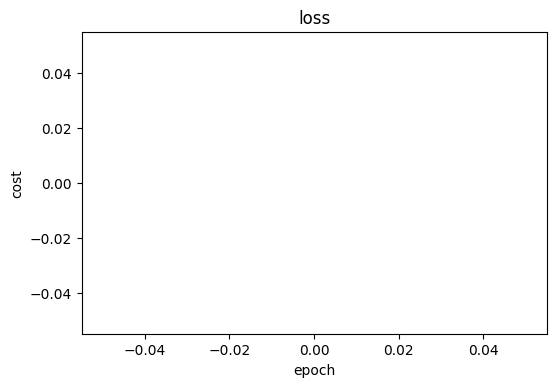

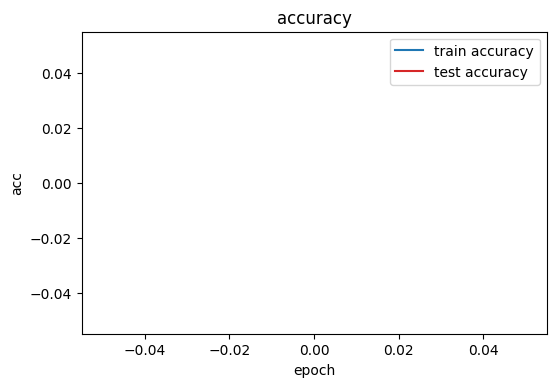

In [38]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

## Model-5) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 512
### Dropout with probability 0.5

In [48]:
import torch
import torch.optim as optim
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False
    
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes)
        self.norm0 = nn.BatchNorm1d(hidden_sizes)
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob) # adding a dropout layer
        self.fc1 = nn.Linear(hidden_sizes, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = 512 
num_classes = CLASS_NUM

# Replace the classifier with the modified custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
# Save the learned parameters of the model
torch.save(model.state_dict(), 'model_5_params.pth')

  0 cost: 341.4507	train_acc: 0.1804	test_acc: 0.4574
  1 cost: 184.7343	train_acc: 0.5411	test_acc: 0.5726
  2 cost: 129.5647	train_acc: 0.6558	test_acc: 0.6093
  3 cost: 100.0780	train_acc: 0.7216	test_acc: 0.6327
  4 cost: 82.8100	train_acc: 0.7618	test_acc: 0.6227
  5 cost: 68.6094	train_acc: 0.7987	test_acc: 0.6561
  6 cost: 60.0335	train_acc: 0.8237	test_acc: 0.6678
  7 cost: 51.6683	train_acc: 0.8478	test_acc: 0.6678
  8 cost: 44.7687	train_acc: 0.8691	test_acc: 0.6511
  9 cost: 41.1142	train_acc: 0.8814	test_acc: 0.6561
 10 cost: 36.2105	train_acc: 0.8932	test_acc: 0.6761
 11 cost: 32.9550	train_acc: 0.9001	test_acc: 0.6861
 12 cost: 31.2415	train_acc: 0.9066	test_acc: 0.6845
 13 cost: 27.4806	train_acc: 0.9205	test_acc: 0.6878
 14 cost: 25.1309	train_acc: 0.9273	test_acc: 0.6795
 15 cost: 24.9546	train_acc: 0.9288	test_acc: 0.6795
 16 cost: 23.8309	train_acc: 0.9322	test_acc: 0.6811
 17 cost: 21.6149	train_acc: 0.9348	test_acc: 0.6878
 18 cost: 19.8765	train_acc: 0.9461	test_a

In [50]:
# Count the number of parameters in the custom classifier
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)

print(f"Total parameters in the custom classifier: {total_params}")

Total parameters in the custom classifier: 2174152


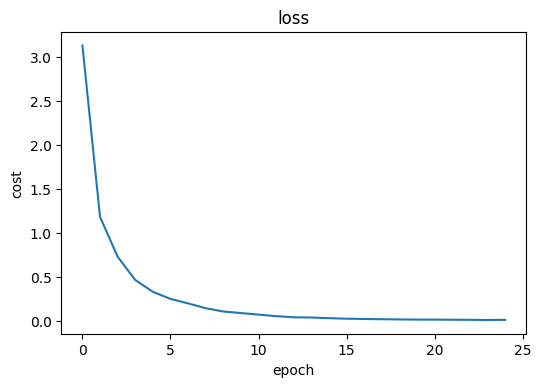

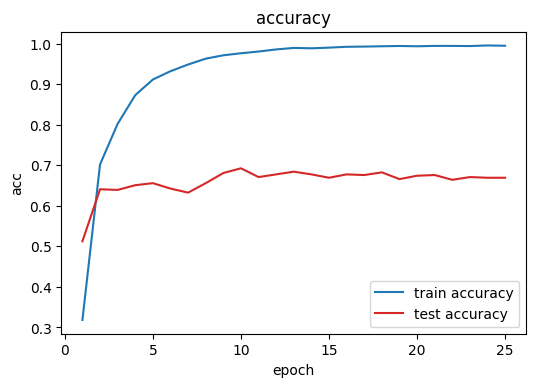

In [51]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [52]:
summary(custom_classifier, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,967,104
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 200]         205,000
Total params: 2,174,152
Trainable params: 2,174,152
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 8.29
Estimated Total Size (MB): 8.33
----------------------------------------------------------------


## Model-6) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 1024
### Dropout with probability 0.5

In [54]:
import torch
import torch.optim as optim
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False
    
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes)
        self.norm0 = nn.BatchNorm1d(hidden_sizes)
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob) # adding a dropout layer
        self.fc1 = nn.Linear(hidden_sizes, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = 1024 
num_classes = CLASS_NUM

# Replace the classifier with the modified custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
# Save the learned parameters of the model
torch.save(model.state_dict(), 'model_6_params.pth')

  0 cost: 306.5729	train_acc: 0.2363	test_acc: 0.5326
  1 cost: 137.9658	train_acc: 0.6059	test_acc: 0.6194
  2 cost: 90.6992	train_acc: 0.7361	test_acc: 0.6411
  3 cost: 68.4707	train_acc: 0.7968	test_acc: 0.6494
  4 cost: 52.9893	train_acc: 0.8371	test_acc: 0.6561
  5 cost: 42.8105	train_acc: 0.8754	test_acc: 0.6594
  6 cost: 36.3964	train_acc: 0.8886	test_acc: 0.6678
  7 cost: 30.6098	train_acc: 0.9123	test_acc: 0.6895
  8 cost: 27.1179	train_acc: 0.9151	test_acc: 0.6694
  9 cost: 22.6934	train_acc: 0.9372	test_acc: 0.6745
 10 cost: 19.6587	train_acc: 0.9422	test_acc: 0.6811
 11 cost: 18.1429	train_acc: 0.9475	test_acc: 0.6761
 12 cost: 15.6653	train_acc: 0.9555	test_acc: 0.6711
 13 cost: 14.6096	train_acc: 0.9572	test_acc: 0.6861
 14 cost: 13.2755	train_acc: 0.9627	test_acc: 0.6878
 15 cost: 11.8801	train_acc: 0.9653	test_acc: 0.6711
 16 cost: 10.9177	train_acc: 0.9705	test_acc: 0.6845
 17 cost: 10.0742	train_acc: 0.9711	test_acc: 0.6945
 18 cost: 9.3631	train_acc: 0.9728	test_acc:

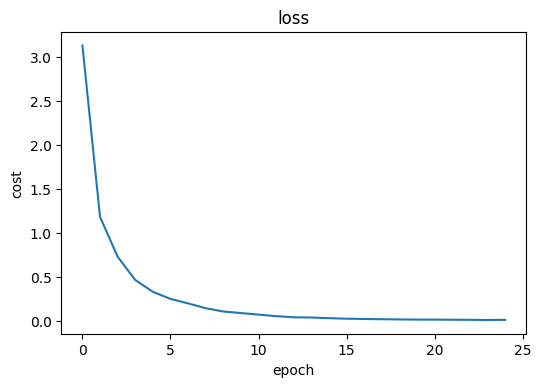

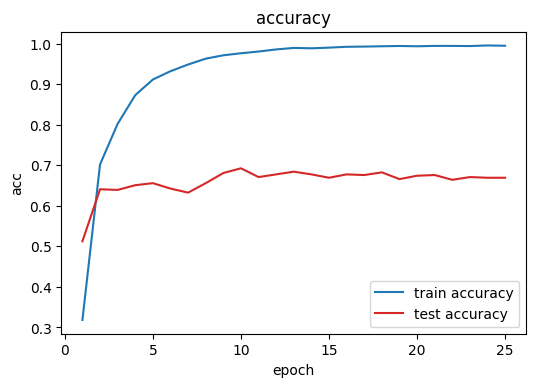

In [57]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [56]:
summary(custom_classifier, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,967,104
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 200]         205,000
Total params: 2,174,152
Trainable params: 2,174,152
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 8.29
Estimated Total Size (MB): 8.33
----------------------------------------------------------------


In [87]:
# ## 2 hidden layers with size 512 and 256 and dropout prob = 0.5
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes[0])
#         self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
#         self.relu1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1920
# input_size = 1920
# hidden_sizes = [512, 256]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM

# # Replace the classifier with the modified custom architecture
# custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
# model.classifier = custom_classifier

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
# # Save the learned parameters of the model

  0 cost: 408.4241	train_acc: 0.0549	test_acc: 0.2588
  1 cost: 307.7905	train_acc: 0.2141	test_acc: 0.3840
  2 cost: 243.3755	train_acc: 0.3331	test_acc: 0.4975
  3 cost: 202.5328	train_acc: 0.4159	test_acc: 0.5292
  4 cost: 174.5771	train_acc: 0.4714	test_acc: 0.5726
  5 cost: 158.1929	train_acc: 0.5101	test_acc: 0.6127
  6 cost: 144.0858	train_acc: 0.5357	test_acc: 0.6060
  7 cost: 131.5137	train_acc: 0.5752	test_acc: 0.6260
  8 cost: 124.3267	train_acc: 0.5952	test_acc: 0.6444
  9 cost: 117.2670	train_acc: 0.6096	test_acc: 0.6594
 10 cost: 109.3003	train_acc: 0.6371	test_acc: 0.6594
 11 cost: 105.5055	train_acc: 0.6439	test_acc: 0.6644
 12 cost: 99.7815	train_acc: 0.6563	test_acc: 0.6845
 13 cost: 93.3252	train_acc: 0.6758	test_acc: 0.6661
 14 cost: 91.5441	train_acc: 0.6892	test_acc: 0.6711
 15 cost: 87.6176	train_acc: 0.6854	test_acc: 0.6861
 16 cost: 81.9413	train_acc: 0.7131	test_acc: 0.6811
 17 cost: 81.1349	train_acc: 0.7171	test_acc: 0.6828
 18 cost: 79.1006	train_acc: 0.727

In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models
from collections import OrderedDict
## 2 hidden layers with size 1024 and 1024 and dropout prob = 0.7
# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = [1024, 1024] 
num_classes = CLASS_NUM

# Replace the classifier with the modified custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
# Save the learned parameters of the model

  0 cost: 320.7954	train_acc: 0.2428	test_acc: 0.4942
  1 cost: 133.7889	train_acc: 0.6185	test_acc: 0.5960
  2 cost: 89.9377	train_acc: 0.7399	test_acc: 0.6344
  3 cost: 66.8647	train_acc: 0.8037	test_acc: 0.6678
  4 cost: 53.6313	train_acc: 0.8387	test_acc: 0.6761
  5 cost: 43.9146	train_acc: 0.8671	test_acc: 0.6461
  6 cost: 35.7517	train_acc: 0.8936	test_acc: 0.6578
  7 cost: 30.8663	train_acc: 0.9066	test_acc: 0.6644
  8 cost: 27.8039	train_acc: 0.9136	test_acc: 0.6778
  9 cost: 24.7052	train_acc: 0.9242	test_acc: 0.6628
 10 cost: 20.7744	train_acc: 0.9370	test_acc: 0.6745
 11 cost: 18.6652	train_acc: 0.9440	test_acc: 0.6728
 12 cost: 17.0132	train_acc: 0.9464	test_acc: 0.6828
 13 cost: 15.0929	train_acc: 0.9563	test_acc: 0.6644
 14 cost: 13.9961	train_acc: 0.9559	test_acc: 0.6828
 15 cost: 12.2617	train_acc: 0.9637	test_acc: 0.6628
 16 cost: 11.0577	train_acc: 0.9685	test_acc: 0.6644
 17 cost: 10.8174	train_acc: 0.9685	test_acc: 0.6678
 18 cost: 10.2174	train_acc: 0.9711	test_acc

## Model-3) Network-in-Network Architecture 
### Using N-i-N architecture with 2 hidden layers of size 512 and dropout with probability of 0.5

In [66]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: my custom architecture
# Define a custom classifier with fully connected layers and dropout
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU(inplace=True))
        self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
        # Network in network architecture starts from here
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU(inplace=True))
            self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        # Network in network architecture ends here
        
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920 (for DenseNet201)
input_size = 1920
hidden_sizes = [512, 512]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes).to(device)
model.classifier = custom_classifier

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)



  0 cost: 391.6077	train_acc: 0.0728	test_acc: 0.3005
  1 cost: 261.7989	train_acc: 0.2945	test_acc: 0.4741
  2 cost: 199.0987	train_acc: 0.4159	test_acc: 0.5442
  3 cost: 162.3158	train_acc: 0.4981	test_acc: 0.5893
  4 cost: 141.0804	train_acc: 0.5487	test_acc: 0.6294
  5 cost: 124.1469	train_acc: 0.5970	test_acc: 0.6194
  6 cost: 113.0957	train_acc: 0.6304	test_acc: 0.6461
  7 cost: 104.7380	train_acc: 0.6489	test_acc: 0.6411
  8 cost: 97.9879	train_acc: 0.6695	test_acc: 0.6628
  9 cost: 90.1160	train_acc: 0.6880	test_acc: 0.6544
 10 cost: 84.3900	train_acc: 0.7021	test_acc: 0.6761
 11 cost: 80.2748	train_acc: 0.7214	test_acc: 0.6861
 12 cost: 77.1393	train_acc: 0.7305	test_acc: 0.6761
 13 cost: 71.0923	train_acc: 0.7475	test_acc: 0.6778
 14 cost: 67.0876	train_acc: 0.7631	test_acc: 0.6878
 15 cost: 65.6999	train_acc: 0.7703	test_acc: 0.6795
 16 cost: 63.0157	train_acc: 0.7792	test_acc: 0.6811
 17 cost: 59.4729	train_acc: 0.7915	test_acc: 0.6811
 18 cost: 58.7514	train_acc: 0.7881	te

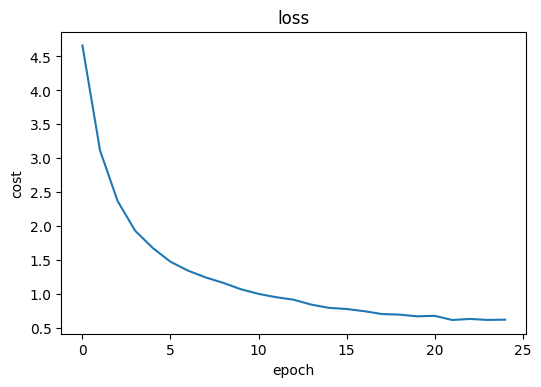

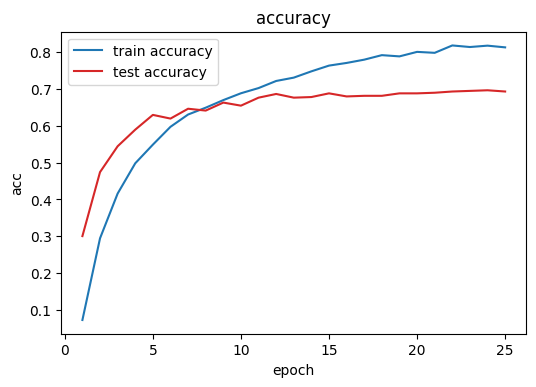

In [67]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [68]:
summary(custom_classifier, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         983,552
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
       BatchNorm1d-6                  [-1, 512]           1,024
              ReLU-7                  [-1, 512]               0
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 200]         102,600
Total params: 1,350,856
Trainable params: 1,350,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 5.15
Estimated Total Size (MB): 5.19
---------------------------------------

In [ ]:
# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count parameters excluding pretrained weights
total_trainable_params = count_parameters(model._fc)
print("Total number of trainable parameters:", total_trainable_params)
torch.save(model.state_dict(), 'model_3_params.pth')

In [20]:
# ## hidden size 256 neurons 
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from torchvision import models
# from collections import OrderedDict

# # Step 1: Pretrain the model on ImageNet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.densenet201(pretrained=True).to(device)

# # Freeze layers
# for param in model.parameters():
#     param.requires_grad = False

# # Step 2: my custom architecture
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomClassifier, self).__init__()
#         self.hidden_layers = nn.ModuleList()
#         self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
#         self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[0]))
#         self.hidden_layers.append(nn.ReLU(inplace=True))
#         self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
#         for i in range(len(hidden_sizes) - 1):
#             self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
#             self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
#             self.hidden_layers.append(nn.ReLU(inplace=True))
#             self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
#         self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

#     def forward(self, x):
#         for layer in self.hidden_layers:
#             x = layer(x)
#         x = self.output_layer(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1920 (for DenseNet201)
# input_size = 1920
# hidden_sizes = [256, 256]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM

# # Replace the classifier with the custom architecture
# custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes).to(device)
# model.classifier = custom_classifier

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)


  0 cost: 422.1335	train_acc: 0.0411	test_acc: 0.1920
  1 cost: 335.3744	train_acc: 0.1451	test_acc: 0.3306
  2 cost: 272.9938	train_acc: 0.2532	test_acc: 0.4190
  3 cost: 234.7978	train_acc: 0.3216	test_acc: 0.4758
  4 cost: 206.5400	train_acc: 0.3770	test_acc: 0.5175
  5 cost: 186.6859	train_acc: 0.4189	test_acc: 0.5543
  6 cost: 174.0907	train_acc: 0.4458	test_acc: 0.5876
  7 cost: 160.6385	train_acc: 0.4745	test_acc: 0.6060
  8 cost: 151.7250	train_acc: 0.5010	test_acc: 0.6077
  9 cost: 144.3140	train_acc: 0.5259	test_acc: 0.6177
 10 cost: 138.0309	train_acc: 0.5405	test_acc: 0.6377
 11 cost: 132.5661	train_acc: 0.5475	test_acc: 0.6411
 12 cost: 127.7225	train_acc: 0.5635	test_acc: 0.6594
 13 cost: 121.9176	train_acc: 0.5924	test_acc: 0.6494
 14 cost: 119.2627	train_acc: 0.5972	test_acc: 0.6444
 15 cost: 114.4018	train_acc: 0.6069	test_acc: 0.6461
 16 cost: 111.2620	train_acc: 0.6085	test_acc: 0.6361
 17 cost: 110.0316	train_acc: 0.6174	test_acc: 0.6411
 18 cost: 107.5212	train_acc

## Model-4) Network-in-Network Architecture 
### Using N-i-N architecture with 2 hidden layers of size 1024 and dropout with probability of 0.5

In [73]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: my custom architecture
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        """Custom classifier architecture with fully connected layers and dropout.

        Args:
            input_size (int): Input size.
            hidden_sizes (list): List of hidden layer sizes.
            num_classes (int): Number of output classes.
            dropout_prob (float, optional): Dropout probability. Defaults to 0.7.
        """
        super(CustomClassifier, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU(inplace=True))
        self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
        # Network in network architecture starts from here
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU(inplace=True))
            self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        # Network in network architecture ends here
        
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, x):
        """Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920 (for DenseNet201)
input_size = 1920
hidden_sizes = [1024, 1024] 
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes).to(device)
model.classifier = custom_classifier

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'model_4_params.pth')


  0 cost: 352.1422	train_acc: 0.1373	test_acc: 0.3890
  1 cost: 191.6980	train_acc: 0.4282	test_acc: 0.5509
  2 cost: 137.2622	train_acc: 0.5716	test_acc: 0.5893
  3 cost: 113.9223	train_acc: 0.6278	test_acc: 0.6027
  4 cost: 96.5334	train_acc: 0.6778	test_acc: 0.6644
  5 cost: 81.3075	train_acc: 0.7288	test_acc: 0.6528
  6 cost: 74.1639	train_acc: 0.7409	test_acc: 0.6528
  7 cost: 67.2690	train_acc: 0.7594	test_acc: 0.6494
  8 cost: 59.2411	train_acc: 0.7918	test_acc: 0.6661
  9 cost: 53.0536	train_acc: 0.8124	test_acc: 0.6761
 10 cost: 48.6160	train_acc: 0.8239	test_acc: 0.6828
 11 cost: 45.9166	train_acc: 0.8332	test_acc: 0.6778
 12 cost: 41.1914	train_acc: 0.8528	test_acc: 0.6761
 13 cost: 37.3567	train_acc: 0.8630	test_acc: 0.6745
 14 cost: 33.7719	train_acc: 0.8821	test_acc: 0.6912
 15 cost: 30.9761	train_acc: 0.8929	test_acc: 0.6778
 16 cost: 30.2227	train_acc: 0.8921	test_acc: 0.6845
 17 cost: 28.4586	train_acc: 0.8982	test_acc: 0.6978
 18 cost: 26.5546	train_acc: 0.9073	test_a

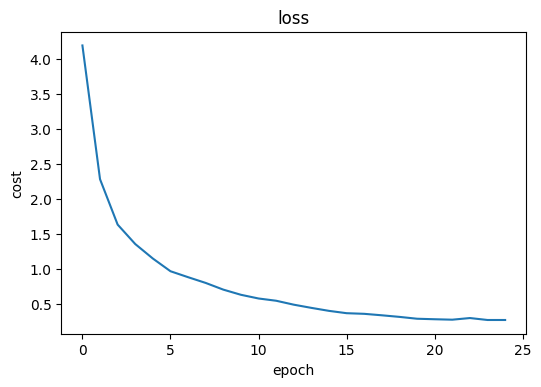

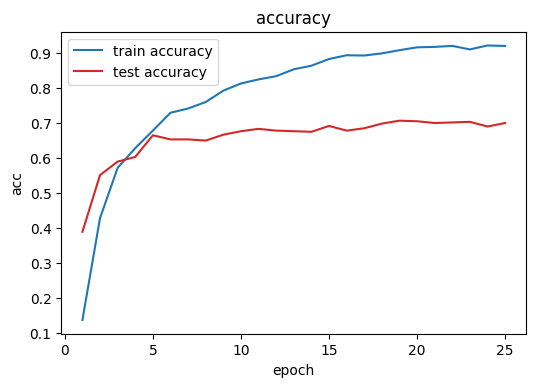

In [74]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [75]:
summary(custom_classifier, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,967,104
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
       BatchNorm1d-6                 [-1, 1024]           2,048
              ReLU-7                 [-1, 1024]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 200]         205,000
Total params: 3,225,800
Trainable params: 3,225,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.31
Estimated Total Size (MB): 12.38
-------------------------------------

## increasing dropout to 0.7 

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Step 2: Define your custom architecture
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
        super(CustomClassifier, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU(inplace=True))
        self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            self.hidden_layers.append(nn.ReLU(inplace=True))
            self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920 (for DenseNet201)
input_size = 1920
hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM

# Replace the classifier with the custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes).to(device)
model.classifier = custom_classifier

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'model_params.pth')


In [ ]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [ ]:
summary(custom_classifier, (input_size,))

In [59]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from torchvision import models
# from collections import OrderedDict

# # Step 1: Pretrain the model on ImageNet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.densenet201(pretrained=True).to(device)

# # Freeze layers
# for param in model.parameters():
#     param.requires_grad = False

# # Step 2: Define your custom architecture
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
#         super(CustomClassifier, self).__init__()
#         self.hidden_layers = nn.ModuleList()
#         self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
#         self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[0]))
#         self.hidden_layers.append(nn.ReLU(inplace=True))
#         self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
#         for i in range(len(hidden_sizes) - 1):
#             self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
#             self.hidden_layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
#             self.hidden_layers.append(nn.ReLU(inplace=True))
#             self.hidden_layers.append(nn.Dropout(dropout_prob))  # Add dropout
        
#         self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

#     def forward(self, x):
#         for layer in self.hidden_layers:
#             x = layer(x)
#         x = self.output_layer(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1920 (for DenseNet201)
# input_size = 1920
# hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM

# # Replace the classifier with the custom architecture
# custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes).to(device)
# model.classifier = custom_classifier

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# # Save the learned parameters of the model
# torch.save(model.state_dict(), 'model_params.pth')


  0 cost: 418.6052	train_acc: 0.0408	test_acc: 0.2821
  1 cost: 295.7434	train_acc: 0.1826	test_acc: 0.4441
  2 cost: 238.3363	train_acc: 0.2793	test_acc: 0.5092
  3 cost: 204.8856	train_acc: 0.3542	test_acc: 0.5342
  4 cost: 185.8858	train_acc: 0.4082	test_acc: 0.5910
  5 cost: 167.2230	train_acc: 0.4454	test_acc: 0.5826
  6 cost: 154.8993	train_acc: 0.4842	test_acc: 0.6294
  7 cost: 147.0213	train_acc: 0.5049	test_acc: 0.6277
  8 cost: 138.7200	train_acc: 0.5283	test_acc: 0.6394
  9 cost: 134.2829	train_acc: 0.5440	test_acc: 0.6561
 10 cost: 124.2581	train_acc: 0.5713	test_acc: 0.6561
 11 cost: 122.4693	train_acc: 0.5709	test_acc: 0.6628
 12 cost: 114.4231	train_acc: 0.5993	test_acc: 0.6778
 13 cost: 110.2734	train_acc: 0.6141	test_acc: 0.6728
 14 cost: 104.7845	train_acc: 0.6237	test_acc: 0.6761
 15 cost: 102.6437	train_acc: 0.6469	test_acc: 0.6795
 16 cost: 99.4510	train_acc: 0.6445	test_acc: 0.6761
 17 cost: 94.1226	train_acc: 0.6576	test_acc: 0.6878
 18 cost: 91.5130	train_acc: 0

In [71]:
# # Load the saved parameters
# state_dict = torch.load('model_params.pth')

# # #Print the keys of the state dictionary
# # print(state_dict.keys())

# # Access and print specific weights
# print(len(state_dict['classifier.hidden_layers.0.bias']))


1024


In [76]:
# total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
# print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 3225800


In [78]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 2174152


In [104]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 1659592


In [108]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from torchvision import models
# from collections import OrderedDict

# # Step 1: Pretrain the model on ImageNet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.densenet201(pretrained=True).to(device)

# # Freeze layers
# for param in model.parameters():
#     param.requires_grad = False

# # Step 2: Define your custom architecture
# class CustomNestedClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomNestedClassifier, self).__init__()
#         self.hidden_layers = nn.ModuleList()
        
#         # First layer
#         self.hidden_layers.append(nn.Sequential(
#             nn.Linear(input_size, hidden_sizes[0]),
#             nn.BatchNorm1d(hidden_sizes[0]),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout_prob)
#         ))
        
#         # Nested network
#         nested_layers = []
#         for i in range(len(hidden_sizes) - 1):
#             nested_layers.extend([
#                 nn.Linear(hidden_sizes[i], hidden_sizes[i+1]),
#                 nn.BatchNorm1d(hidden_sizes[i+1]),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout(dropout_prob)
#             ])
#         self.nested_network = nn.Sequential(*nested_layers)
        
#         # Output layer
#         self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)

#     def forward(self, x):
#         x = self.hidden_layers[0](x)
#         x = self.nested_network(x)
#         x = self.output_layer(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1920 (for DenseNet201)
# input_size = 1920
# hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM

# # Replace the classifier with the custom architecture
# custom_classifier = CustomNestedClassifier(input_size, hidden_sizes, num_classes).to(device)
# model.classifier = custom_classifier

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)


  0 cost: 347.4472	train_acc: 0.1498	test_acc: 0.3873
  1 cost: 190.6243	train_acc: 0.4410	test_acc: 0.5442
  2 cost: 138.4968	train_acc: 0.5655	test_acc: 0.6010
  3 cost: 113.2020	train_acc: 0.6326	test_acc: 0.6327
  4 cost: 95.1069	train_acc: 0.6754	test_acc: 0.6344
  5 cost: 83.4502	train_acc: 0.7151	test_acc: 0.6394
  6 cost: 73.4573	train_acc: 0.7481	test_acc: 0.6444
  7 cost: 67.4155	train_acc: 0.7672	test_acc: 0.6728
  8 cost: 62.4528	train_acc: 0.7761	test_acc: 0.6711
  9 cost: 53.8644	train_acc: 0.8022	test_acc: 0.6594
 10 cost: 51.8257	train_acc: 0.8093	test_acc: 0.6611
 11 cost: 47.8979	train_acc: 0.8287	test_acc: 0.6728
 12 cost: 44.8831	train_acc: 0.8343	test_acc: 0.6745
 13 cost: 39.9060	train_acc: 0.8582	test_acc: 0.6694
 14 cost: 35.1944	train_acc: 0.8703	test_acc: 0.6811
 15 cost: 33.0066	train_acc: 0.8790	test_acc: 0.6728
 16 cost: 31.4195	train_acc: 0.8866	test_acc: 0.6644
 17 cost: 29.7643	train_acc: 0.8934	test_acc: 0.6728
 18 cost: 27.6412	train_acc: 0.8999	test_a

In [111]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 3432848


In [23]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 3018752


## Model-5) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin densenet201 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 512
### Dropout with probability of 0.5

In [25]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from collections import OrderedDict

# Step 1: Pretrain the model on ImageNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet201(pretrained=True).to(device)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1920
input_size = 1920
hidden_sizes = [512, 512]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM

# Replace the classifier with the modified custom architecture
custom_classifier = CustomClassifier(input_size, hidden_sizes, num_classes)
model.classifier = custom_classifier

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)
# Save the learned parameters of the model

  0 cost: 358.2457	train_acc: 0.1791	test_acc: 0.4708
  1 cost: 184.2758	train_acc: 0.5264	test_acc: 0.5943
  2 cost: 128.8363	train_acc: 0.6615	test_acc: 0.6194
  3 cost: 97.7583	train_acc: 0.7290	test_acc: 0.6177
  4 cost: 81.1255	train_acc: 0.7672	test_acc: 0.6544
  5 cost: 69.0918	train_acc: 0.7994	test_acc: 0.6561
  6 cost: 58.9226	train_acc: 0.8252	test_acc: 0.6644
  7 cost: 52.6985	train_acc: 0.8393	test_acc: 0.6511
  8 cost: 45.1789	train_acc: 0.8656	test_acc: 0.6728
  9 cost: 41.4402	train_acc: 0.8704	test_acc: 0.6845
 10 cost: 38.9816	train_acc: 0.8727	test_acc: 0.6811
 11 cost: 32.5993	train_acc: 0.8997	test_acc: 0.6845
 12 cost: 30.5378	train_acc: 0.9066	test_acc: 0.7062
 13 cost: 29.5944	train_acc: 0.9092	test_acc: 0.7028
 14 cost: 27.6037	train_acc: 0.9142	test_acc: 0.6895
 15 cost: 24.2546	train_acc: 0.9251	test_acc: 0.6811
 16 cost: 23.3540	train_acc: 0.9262	test_acc: 0.7112
 17 cost: 21.4011	train_acc: 0.9388	test_acc: 0.6995
 18 cost: 21.3988	train_acc: 0.9292	test_ac

In [26]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 1247232


## Model-7) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset using MobileNetV2 architecture and add classifier on top of it for classification. 
### 2 Hidden Layer of size 1024
### Dropout with probability of 0.5

In [76]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for MobileNetV2)
input_size = 1280
hidden_sizes = [1024, 1024] 
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier
model.classifier = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'mobilenet_custom_classifier_1024_2.pth')


  0 cost: 382.2889	train_acc: 0.0652	test_acc: 0.1603
  1 cost: 264.0203	train_acc: 0.2111	test_acc: 0.2437
  2 cost: 210.4442	train_acc: 0.3288	test_acc: 0.3306
  3 cost: 180.2742	train_acc: 0.3935	test_acc: 0.4407
  4 cost: 157.0008	train_acc: 0.4606	test_acc: 0.4658
  5 cost: 139.4736	train_acc: 0.5079	test_acc: 0.4908
  6 cost: 123.2381	train_acc: 0.5605	test_acc: 0.5710
  7 cost: 113.6881	train_acc: 0.5911	test_acc: 0.5459
  8 cost: 99.4066	train_acc: 0.6475	test_acc: 0.6010
  9 cost: 87.3977	train_acc: 0.6853	test_acc: 0.6077
 10 cost: 77.5637	train_acc: 0.7140	test_acc: 0.6244
 11 cost: 72.7680	train_acc: 0.7301	test_acc: 0.6277
 12 cost: 60.9853	train_acc: 0.7687	test_acc: 0.6644
 13 cost: 54.7152	train_acc: 0.7950	test_acc: 0.6828
 14 cost: 50.0780	train_acc: 0.8054	test_acc: 0.6962
 15 cost: 43.3306	train_acc: 0.8421	test_acc: 0.6878
 16 cost: 36.7220	train_acc: 0.8612	test_acc: 0.7012
 17 cost: 32.0726	train_acc: 0.8849	test_acc: 0.7012
 18 cost: 28.3324	train_acc: 0.8923	te

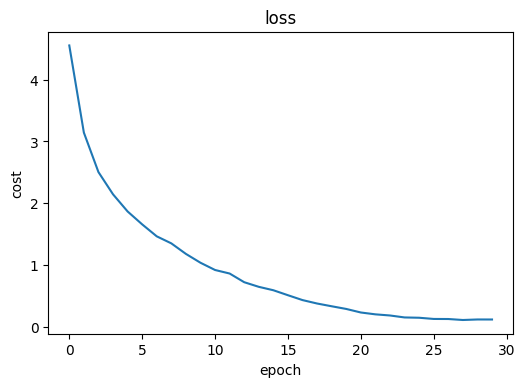

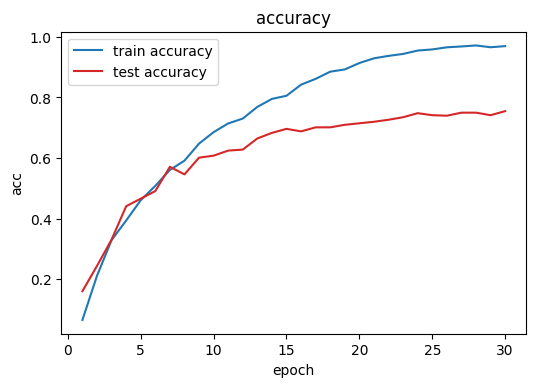

In [77]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [81]:
summary(model.classifier, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,311,744
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
       BatchNorm1d-6                 [-1, 1024]           2,048
              ReLU-7                 [-1, 1024]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 200]         205,000
Total params: 2,570,440
Trainable params: 2,570,440
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 9.81
Estimated Total Size (MB): 9.87
---------------------------------------

In [80]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 3225800


## Model-11) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin efficientnet-b0 architecture and add classifier on top of it for classification. 
### 2 Hidden Layer of size 1024
### Dropout with probability of 0.5

In [83]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.6):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
input_size = 1280
hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier
model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'efficientnet_custom_classifier_1024_2.pth')


Loaded pretrained weights for efficientnet-b0
  0 cost: 405.4229	train_acc: 0.0541	test_acc: 0.2120
  1 cost: 253.8324	train_acc: 0.2469	test_acc: 0.3973
  2 cost: 181.3546	train_acc: 0.4044	test_acc: 0.5125
  3 cost: 139.9573	train_acc: 0.5294	test_acc: 0.5676
  4 cost: 110.7930	train_acc: 0.6063	test_acc: 0.5810
  5 cost: 94.2711	train_acc: 0.6710	test_acc: 0.6144
  6 cost: 76.3461	train_acc: 0.7305	test_acc: 0.6761
  7 cost: 63.1358	train_acc: 0.7744	test_acc: 0.6912
  8 cost: 52.6474	train_acc: 0.8035	test_acc: 0.7028
  9 cost: 46.5238	train_acc: 0.8289	test_acc: 0.7112
 10 cost: 39.4777	train_acc: 0.8573	test_acc: 0.7429
 11 cost: 29.7406	train_acc: 0.8951	test_acc: 0.7312
 12 cost: 25.6340	train_acc: 0.9062	test_acc: 0.7446
 13 cost: 21.6555	train_acc: 0.9220	test_acc: 0.7379
 14 cost: 17.1416	train_acc: 0.9401	test_acc: 0.7713
 15 cost: 14.1761	train_acc: 0.9513	test_acc: 0.7412
 16 cost: 12.0884	train_acc: 0.9570	test_acc: 0.7663
 17 cost: 10.8081	train_acc: 0.9624	test_acc: 0.

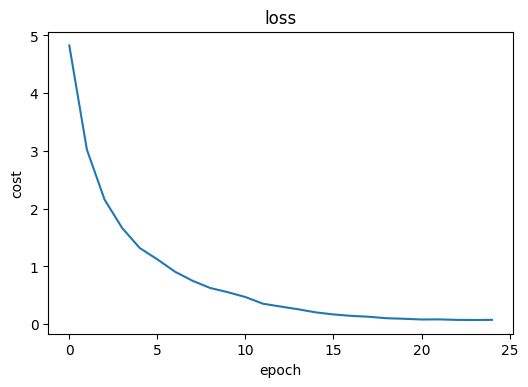

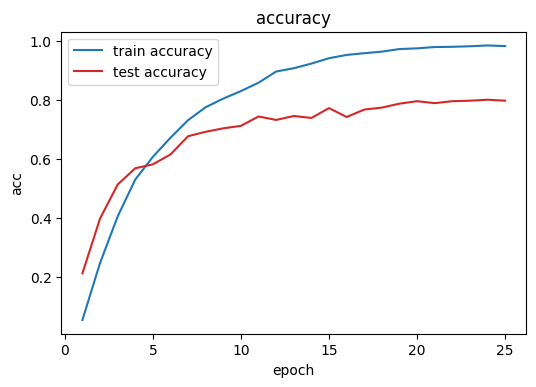

In [84]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [85]:
summary(model._fc, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,311,744
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                 [-1, 1024]       1,049,600
       BatchNorm1d-6                 [-1, 1024]           2,048
              ReLU-7                 [-1, 1024]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 200]         205,000
Total params: 2,570,440
Trainable params: 2,570,440
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 9.81
Estimated Total Size (MB): 9.87
---------------------------------------

In [51]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from efficientnet_pytorch import EfficientNet
# from collections import OrderedDict

# # Define your custom classifier
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes[0])
#         self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
#         self.relu1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
# input_size = 1280
# hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# # Load pre-trained EfficientNet model
# model = EfficientNet.from_pretrained('efficientnet-b0')

# # Modify the classifier
# model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 25
# test_period = 1

# # Define optimizer and scheduler
# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# # Save the learned parameters of the model
# torch.save(model.state_dict(), 'efficientnet_custom_classifier_1024_2.pth')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
  0 cost: 368.4401	train_acc: 0.1044	test_acc: 0.2788
  1 cost: 200.8343	train_acc: 0.3753	test_acc: 0.4825
  2 cost: 134.8975	train_acc: 0.5533	test_acc: 0.5376
  3 cost: 102.8993	train_acc: 0.6506	test_acc: 0.6544
  4 cost: 81.3270	train_acc: 0.7197	test_acc: 0.6277
  5 cost: 67.4885	train_acc: 0.7538	test_acc: 0.6561
  6 cost: 56.3471	train_acc: 0.7976	test_acc: 0.6828
  7 cost: 47.4234	train_acc: 0.8285	test_acc: 0.6811
  8 cost: 38.5904	train_acc: 0.8565	test_acc: 0.6678
  9 cost: 31.9333	train_acc: 0.8817	test_acc: 0.7145
 10 cost: 28.3639	train_acc: 0.8919	test_acc: 0.7195
 11 cost: 24.1890	train_acc: 0.9094	test_acc: 0.7329
 12 cost: 19.9351	train_acc: 0.9288	test_acc: 0.7346
 13 cost: 14.0745	train_acc: 0.9485	test_acc: 0.7563
 14 cost: 13.6564	train_acc: 0.9516	test_acc: 0.7613
 15 cost: 10.2884	train_acc: 0.9622	test_acc: 0.7596
 16 cost: 8.7109	train_acc: 0.9672	test_acc: 0.7646
 17 cost: 7.4376	train_acc: 0.9731	test_acc: 0.769

In [52]:
total_params = sum(p.numel() for p in custom_classifier.parameters() if p.requires_grad)
print("Total number of parameters in the custom classifier:", total_params)


Total number of parameters in the custom classifier: 3149824


## Model-9) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin efficientnet-b0 architecture and add classifier on top of it for classification. 
### 2 Hidden Layer of size 512
### Dropout with probability of 0.5

In [86]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
input_size = 1280
hidden_sizes = [512, 512]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier
model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'efficientnet_custom_classifier_512_2.pth')


Loaded pretrained weights for efficientnet-b0
  0 cost: 454.4590	train_acc: 0.0111	test_acc: 0.0250
  1 cost: 377.5422	train_acc: 0.0589	test_acc: 0.1770
  2 cost: 317.6650	train_acc: 0.1203	test_acc: 0.2721
  3 cost: 271.4587	train_acc: 0.1824	test_acc: 0.3055
  4 cost: 243.2544	train_acc: 0.2378	test_acc: 0.4290
  5 cost: 211.4702	train_acc: 0.3016	test_acc: 0.4641
  6 cost: 187.4809	train_acc: 0.3648	test_acc: 0.5042
  7 cost: 171.2431	train_acc: 0.4078	test_acc: 0.5476
  8 cost: 152.6126	train_acc: 0.4610	test_acc: 0.5810
  9 cost: 137.9825	train_acc: 0.5095	test_acc: 0.6160
 10 cost: 121.9753	train_acc: 0.5627	test_acc: 0.6377
 11 cost: 109.8574	train_acc: 0.6089	test_acc: 0.6778
 12 cost: 100.7625	train_acc: 0.6258	test_acc: 0.6895
 13 cost: 90.7005	train_acc: 0.6749	test_acc: 0.7195
 14 cost: 81.9612	train_acc: 0.7021	test_acc: 0.7112
 15 cost: 73.5389	train_acc: 0.7362	test_acc: 0.7513
 16 cost: 68.3347	train_acc: 0.7596	test_acc: 0.7496
 17 cost: 63.3044	train_acc: 0.7744	test

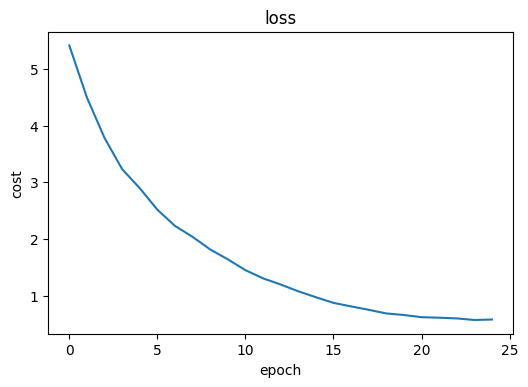

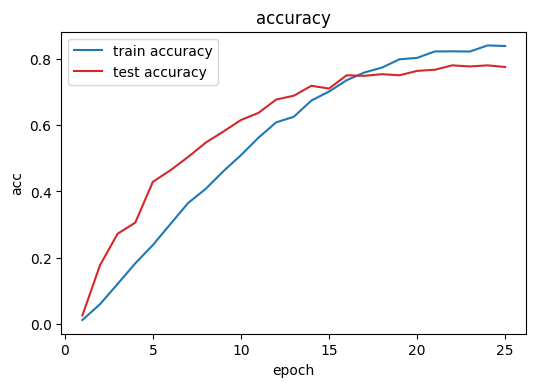

In [87]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [88]:
summary(model._fc, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         655,872
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
       BatchNorm1d-6                  [-1, 512]           1,024
              ReLU-7                  [-1, 512]               0
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 200]         102,600
Total params: 1,023,176
Trainable params: 1,023,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.90
Estimated Total Size (MB): 3.94
---------------------------------------

In [19]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from efficientnet_pytorch import EfficientNet
# from collections import OrderedDict

# # Define your custom classifier
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes[0])
#         self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.norm1 = nn.BatchNorm1d(hidden_sizes[1])
#         self.relu1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(dropout_prob)
#         self.fc2 = nn.Linear(hidden_sizes[1], num_classes)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = self.relu1(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
# input_size = 1280
# hidden_sizes = [512, 512]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# # Load pre-trained EfficientNet model
# model = EfficientNet.from_pretrained('efficientnet-b0')

# # Modify the classifier
# model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# # Define optimizer and scheduler
# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# # Save the learned parameters of the model
# torch.save(model.state_dict(), 'efficientnet_custom_classifier_512_2.pth')


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
  0 cost: 400.8786	train_acc: 0.0563	test_acc: 0.2037
  1 cost: 266.9863	train_acc: 0.2506	test_acc: 0.3523
  2 cost: 193.5058	train_acc: 0.4037	test_acc: 0.5042
  3 cost: 147.4940	train_acc: 0.5129	test_acc: 0.5459
  4 cost: 118.8080	train_acc: 0.6033	test_acc: 0.5626
  5 cost: 97.4769	train_acc: 0.6569	test_acc: 0.6327
  6 cost: 81.4874	train_acc: 0.7071	test_acc: 0.6110
  7 cost: 71.4490	train_acc: 0.7435	test_acc: 0.6544
  8 cost: 60.6965	train_acc: 0.7772	test_acc: 0.6644
  9 cost: 53.6411	train_acc: 0.7983	test_acc: 0.6644
 10 cost: 44.9222	train_acc: 0.8382	test_acc: 0.7112
 11 cost: 38.3223	train_acc: 0.8591	test_acc: 0.7145
 12 cost: 31.9305	train_acc: 0.8834	test_acc: 0.7279
 13 cost: 25.9115	train_acc: 0.9047	test_acc: 0.7596
 14 cost: 21.5286	train_acc: 0.9247	test_acc: 0.7312
 15 cost: 17.7464	train_acc: 0.9398	test_acc: 0.7579
 16 cost: 15.8994	train_acc: 0.9472	test_acc: 0.7346
 17 cost: 13.3515	train_acc: 0.9542	test_acc: 0.

In [22]:
# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count parameters excluding pretrained weights
total_trainable_params = count_parameters(model._fc)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 1023176


## Model-10) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin efficientnet-b0 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 1024
### Dropout with probability of 0.5

In [93]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from efficientnet_pytorch import EfficientNet
# from collections import OrderedDict

# # Define your custom classifier
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes)
#         self.norm0 = nn.BatchNorm1d(hidden_sizes)
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes, num_classes)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
# input_size = 1280
# hidden_sizes = 1024  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# # Load pre-trained EfficientNet model
# model = EfficientNet.from_pretrained('efficientnet-b0')

# # Modify the classifier
# model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 25
# test_period = 1

# # Define optimizer and scheduler
# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# # Save the learned parameters of the model
# torch.save(model.state_dict(), 'efficientnet_custom_classifier_1024_1.pth')


Loaded pretrained weights for efficientnet-b0
  0 cost: 316.3260	train_acc: 0.2000	test_acc: 0.4307
  1 cost: 138.0825	train_acc: 0.5724	test_acc: 0.5793
  2 cost: 87.2940	train_acc: 0.7131	test_acc: 0.6528
  3 cost: 61.2061	train_acc: 0.7924	test_acc: 0.6578
  4 cost: 45.8725	train_acc: 0.8410	test_acc: 0.6728
  5 cost: 33.8009	train_acc: 0.8825	test_acc: 0.7262
  6 cost: 26.1853	train_acc: 0.9101	test_acc: 0.6912
  7 cost: 20.2081	train_acc: 0.9307	test_acc: 0.7479
  8 cost: 14.0338	train_acc: 0.9546	test_acc: 0.7179
  9 cost: 12.7912	train_acc: 0.9544	test_acc: 0.7179
 10 cost: 9.3713	train_acc: 0.9694	test_acc: 0.7396
 11 cost: 8.0498	train_acc: 0.9752	test_acc: 0.7596
 12 cost: 6.3101	train_acc: 0.9789	test_acc: 0.7546
 13 cost: 4.8066	train_acc: 0.9835	test_acc: 0.7730
 14 cost: 3.9432	train_acc: 0.9863	test_acc: 0.7679
 15 cost: 3.0376	train_acc: 0.9898	test_acc: 0.7730
 16 cost: 2.4419	train_acc: 0.9918	test_acc: 0.7730
 17 cost: 2.1062	train_acc: 0.9926	test_acc: 0.7947
 18 co

In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
input_size = 1280
hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier
model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 30
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'efficientnet_custom_classifier_1024_1.pth')


Loaded pretrained weights for efficientnet-b0
  0 cost: 331.0063	train_acc: 0.2056	test_acc: 0.4725
  1 cost: 134.4498	train_acc: 0.5741	test_acc: 0.5876
  2 cost: 84.8999	train_acc: 0.7247	test_acc: 0.6661
  3 cost: 58.9071	train_acc: 0.7981	test_acc: 0.6427
  4 cost: 45.2907	train_acc: 0.8386	test_acc: 0.6745
  5 cost: 36.3848	train_acc: 0.8734	test_acc: 0.6694
  6 cost: 28.8942	train_acc: 0.8975	test_acc: 0.6895
  7 cost: 23.1847	train_acc: 0.9158	test_acc: 0.7012
  8 cost: 17.9424	train_acc: 0.9364	test_acc: 0.7396
  9 cost: 14.1327	train_acc: 0.9514	test_acc: 0.7579
 10 cost: 11.4166	train_acc: 0.9594	test_acc: 0.7613
 11 cost: 8.8607	train_acc: 0.9683	test_acc: 0.7362
 12 cost: 8.6331	train_acc: 0.9685	test_acc: 0.7212
 13 cost: 6.4193	train_acc: 0.9783	test_acc: 0.7763
 14 cost: 5.0845	train_acc: 0.9816	test_acc: 0.7713
 15 cost: 4.5061	train_acc: 0.9842	test_acc: 0.7629
 16 cost: 3.6522	train_acc: 0.9868	test_acc: 0.7629
 17 cost: 2.2747	train_acc: 0.9913	test_acc: 0.7947
 18 c

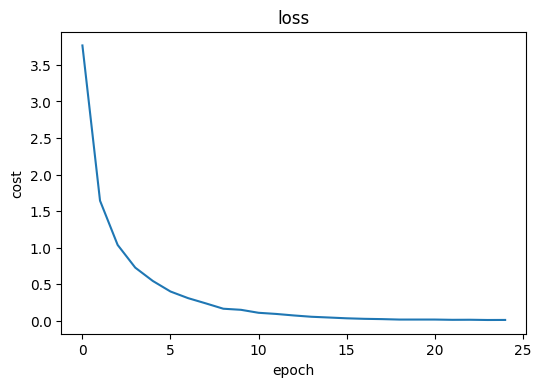

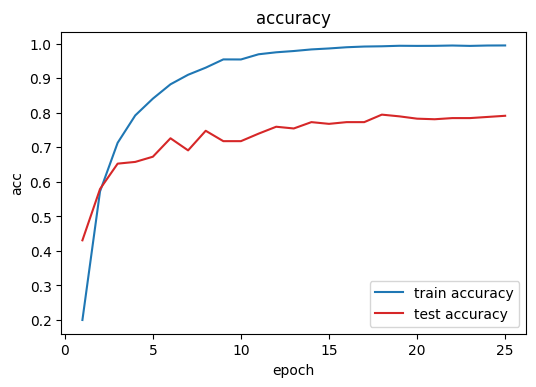

In [94]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [95]:
summary(model._fc, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       1,311,744
       BatchNorm1d-2                 [-1, 1024]           2,048
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 200]         205,000
Total params: 1,518,792
Trainable params: 1,518,792
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.79
Estimated Total Size (MB): 5.83
----------------------------------------------------------------


## Model-8) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset usin efficientnet-b0 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 512
### Dropout with probability of 0.7

In [96]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes)
        self.norm0 = nn.BatchNorm1d(hidden_sizes)
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
input_size = 1280
hidden_sizes = 512  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier
model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'efficientnet_custom_classifier_512_1.pth')
# 

Loaded pretrained weights for efficientnet-b0
  0 cost: 383.6316	train_acc: 0.0875	test_acc: 0.2371
  1 cost: 232.7465	train_acc: 0.3320	test_acc: 0.5075
  2 cost: 161.5310	train_acc: 0.5047	test_acc: 0.6311
  3 cost: 121.6195	train_acc: 0.6074	test_acc: 0.5977
  4 cost: 99.3759	train_acc: 0.6751	test_acc: 0.6861
  5 cost: 77.6813	train_acc: 0.7394	test_acc: 0.6962
  6 cost: 64.5773	train_acc: 0.7781	test_acc: 0.6694
  7 cost: 52.6015	train_acc: 0.8217	test_acc: 0.7295
  8 cost: 44.2663	train_acc: 0.8512	test_acc: 0.7312
  9 cost: 35.0756	train_acc: 0.8832	test_acc: 0.7145
 10 cost: 29.5391	train_acc: 0.8971	test_acc: 0.7446
 11 cost: 22.8231	train_acc: 0.9273	test_acc: 0.7613
 12 cost: 18.7464	train_acc: 0.9377	test_acc: 0.7629
 13 cost: 15.5760	train_acc: 0.9487	test_acc: 0.7746
 14 cost: 13.3853	train_acc: 0.9596	test_acc: 0.7796
 15 cost: 10.2421	train_acc: 0.9681	test_acc: 0.7880
 16 cost: 8.2916	train_acc: 0.9774	test_acc: 0.7880
 17 cost: 7.3738	train_acc: 0.9791	test_acc: 0.789

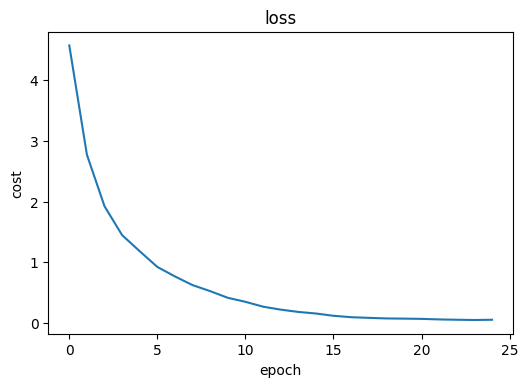

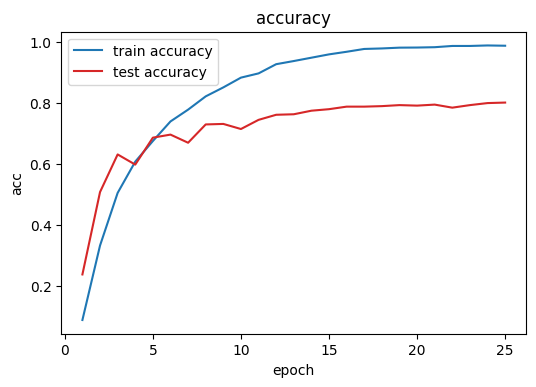

In [97]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [98]:
summary(model._fc, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         655,872
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 200]         102,600
Total params: 759,496
Trainable params: 759,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.90
Estimated Total Size (MB): 2.92
----------------------------------------------------------------


In [27]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from efficientnet_pytorch import EfficientNet
# from collections import OrderedDict

# # Define your custom classifier
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes[0])
#         self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         return x

# # Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
# input_size = 1280
# hidden_sizes = [512, 512]  # Adjust the hidden layer sizes as needed
# num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# # Load pre-trained EfficientNet model
# model = EfficientNet.from_pretrained('efficientnet-b0')

# # Modify the classifier
# model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# # Move the model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# # Define optimizer and scheduler
# optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the model
# train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# # Save the learned parameters of the model
# torch.save(model.state_dict(), 'efficientnet_custom_classifier_512_1.pth')


Loaded pretrained weights for efficientnet-b0
  0 cost: 360.8584	train_acc: 0.1525	test_acc: 0.3356
  1 cost: 178.1217	train_acc: 0.4858	test_acc: 0.5225
  2 cost: 114.0563	train_acc: 0.6543	test_acc: 0.6177
  3 cost: 79.1407	train_acc: 0.7496	test_acc: 0.6578
  4 cost: 59.2670	train_acc: 0.8032	test_acc: 0.6661
  5 cost: 45.3700	train_acc: 0.8502	test_acc: 0.6561
  6 cost: 39.2214	train_acc: 0.8664	test_acc: 0.7012
  7 cost: 31.4547	train_acc: 0.8947	test_acc: 0.7479
  8 cost: 23.2323	train_acc: 0.9234	test_acc: 0.7295
  9 cost: 18.5164	train_acc: 0.9368	test_acc: 0.7513
 10 cost: 16.1458	train_acc: 0.9407	test_acc: 0.7179
 11 cost: 13.2741	train_acc: 0.9563	test_acc: 0.7679
 12 cost: 10.0755	train_acc: 0.9674	test_acc: 0.7563
 13 cost: 7.8905	train_acc: 0.9728	test_acc: 0.7563
 14 cost: 7.2289	train_acc: 0.9766	test_acc: 0.7462
 15 cost: 5.3573	train_acc: 0.9837	test_acc: 0.7496
 16 cost: 3.8084	train_acc: 0.9872	test_acc: 0.7713
 17 cost: 3.6560	train_acc: 0.9872	test_acc: 0.7880
 1

In [28]:
# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count parameters excluding pretrained weights
total_trainable_params = count_parameters(model._fc)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 919552


## Model-12) Basic Transfer Learning Architecture: 
### Pretrain on ImageNet dataset using mobilenet_v2 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 512
### Dropout with probability of 0.5

In [99]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes)
        self.norm0 = nn.BatchNorm1d(hidden_sizes)
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes, num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for MobileNetV2)
input_size = 1280
hidden_sizes = 512 
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier
model.classifier = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model
costs, train_accs, test_accs = train(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'mobilenet_custom_classifier_512_1.pth')


  0 cost: 405.4039	train_acc: 0.0450	test_acc: 0.1386
  1 cost: 298.4535	train_acc: 0.1529	test_acc: 0.3072
  2 cost: 240.1828	train_acc: 0.2639	test_acc: 0.3890
  3 cost: 201.8260	train_acc: 0.3544	test_acc: 0.4891
  4 cost: 177.8739	train_acc: 0.4141	test_acc: 0.4925
  5 cost: 153.8684	train_acc: 0.4888	test_acc: 0.5492
  6 cost: 133.8931	train_acc: 0.5398	test_acc: 0.5893
  7 cost: 120.9872	train_acc: 0.5818	test_acc: 0.5927
  8 cost: 106.1508	train_acc: 0.6345	test_acc: 0.6528
  9 cost: 96.2690	train_acc: 0.6630	test_acc: 0.6761
 10 cost: 83.4819	train_acc: 0.7038	test_acc: 0.6561
 11 cost: 73.9555	train_acc: 0.7361	test_acc: 0.6678
 12 cost: 64.5947	train_acc: 0.7687	test_acc: 0.6928
 13 cost: 55.2396	train_acc: 0.8041	test_acc: 0.7145
 14 cost: 47.3176	train_acc: 0.8371	test_acc: 0.7179
 15 cost: 41.8048	train_acc: 0.8556	test_acc: 0.7362
 16 cost: 35.6905	train_acc: 0.8806	test_acc: 0.7496
 17 cost: 31.6291	train_acc: 0.8921	test_acc: 0.7379
 18 cost: 27.1283	train_acc: 0.9134	t

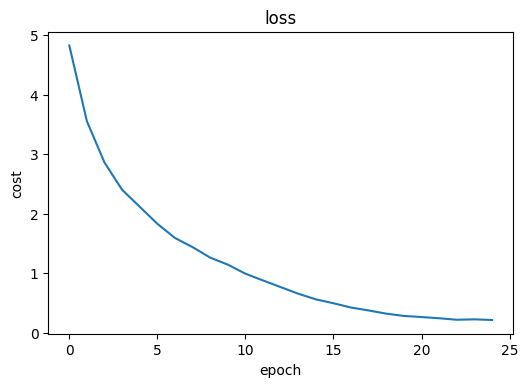

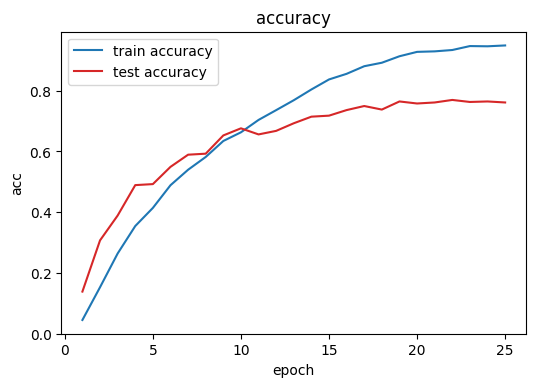

In [100]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [101]:
summary(model.classifier, (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         655,872
       BatchNorm1d-2                  [-1, 512]           1,024
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 200]         102,600
Total params: 759,496
Trainable params: 759,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.90
Estimated Total Size (MB): 2.92
----------------------------------------------------------------


## Model-13) Transfer Learning Architecture + Ensemble Method: 
### Pretrain on ImageNet dataset using shufflenet_v2_x1_0 and mobilenet_v2 architecture and add classifier on top of it for classification. 
### 1 Hidden Layer of size 512
### Dropout with probability of 0.5

In [102]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision.models import shufflenet_v2_x1_0, mobilenet_v2
from collections import OrderedDict

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Load pre-trained ShuffleNet model
shufflenet_model = shufflenet_v2_x1_0(pretrained=True)
shufflenet_classifier = CustomClassifier(1024, [512, 512], 200)  # Input size adjusted to match ShuffleNet
shufflenet_model.fc = shufflenet_classifier

# Load pre-trained MobileNetV2 model
mobilenet_model = mobilenet_v2(pretrained=True)
mobilenet_classifier = CustomClassifier(1280, [512, 512], 200)  # Input size adjusted to match MobileNetV2
mobilenet_model.classifier = mobilenet_classifier

# Define ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x)
        return (x1 + x2) / 2  # Simple averaging for ensemble

ensemble_model = EnsembleModel(shufflenet_model, mobilenet_model)

# Move the ensemble model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1

# Define optimizer and scheduler
optimizer = optim.AdamW(ensemble_model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the ensemble model
costs, train_accs, test_accs = train(ensemble_model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# Save the learned parameters of the ensemble model
torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

  0 cost: 373.1755	train_acc: 0.0895	test_acc: 0.2905
  1 cost: 239.0569	train_acc: 0.3303	test_acc: 0.5058
  2 cost: 173.7983	train_acc: 0.4801	test_acc: 0.5409
  3 cost: 137.8518	train_acc: 0.5761	test_acc: 0.6010
  4 cost: 112.1968	train_acc: 0.6480	test_acc: 0.6561
  5 cost: 94.4693	train_acc: 0.7003	test_acc: 0.6477
  6 cost: 78.7872	train_acc: 0.7422	test_acc: 0.6878
  7 cost: 66.6886	train_acc: 0.7844	test_acc: 0.6778
  8 cost: 53.6530	train_acc: 0.8215	test_acc: 0.7112
  9 cost: 46.5244	train_acc: 0.8462	test_acc: 0.6878
 10 cost: 41.2566	train_acc: 0.8682	test_acc: 0.7329
 11 cost: 31.0259	train_acc: 0.9021	test_acc: 0.7179
 12 cost: 25.7820	train_acc: 0.9190	test_acc: 0.7279
 13 cost: 22.2020	train_acc: 0.9333	test_acc: 0.7412
 14 cost: 17.1698	train_acc: 0.9494	test_acc: 0.7329
 15 cost: 14.4080	train_acc: 0.9607	test_acc: 0.7245
 16 cost: 11.8113	train_acc: 0.9689	test_acc: 0.7329
 17 cost: 9.7112	train_acc: 0.9755	test_acc: 0.7529
 18 cost: 9.2336	train_acc: 0.9768	test_ac

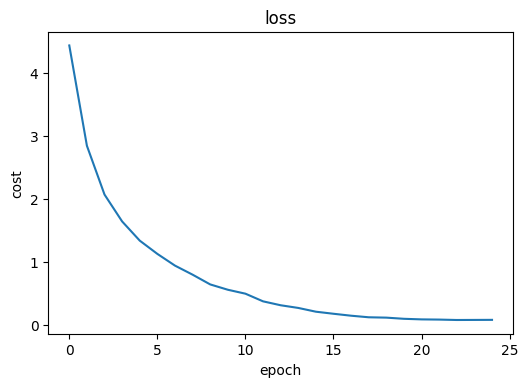

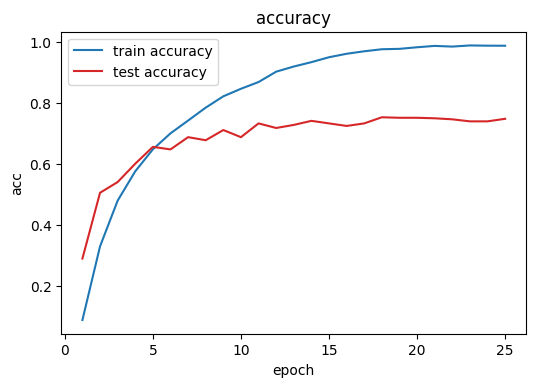

In [103]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

    
draw_cost(costs)
draw_accs(train_accs, test_accs, test_period)

In [22]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from torch.optim import lr_scheduler
# from torchvision.models import shufflenet_v2_x1_0, mobilenet_v2
# from collections import OrderedDict

# # Define your custom classifier
# class CustomClassifier(nn.Module):
#     def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.7):
#         super(CustomClassifier, self).__init__()
#         self.fc0 = nn.Linear(input_size, hidden_sizes[0])
#         self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
#         self.relu0 = nn.ReLU(inplace=True)
#         self.dropout0 = nn.Dropout(dropout_prob)
#         self.fc1 = nn.Linear(hidden_sizes[0], num_classes)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = self.norm0(x)
#         x = self.relu0(x)
#         x = self.dropout0(x)
#         x = self.fc1(x)
#         return x

# # Load pre-trained ShuffleNet model
# shufflenet_model = shufflenet_v2_x1_0(pretrained=True)
# shufflenet_classifier = CustomClassifier(1024, [512, 512], 200)  # Input size adjusted to match ShuffleNet
# shufflenet_model.fc = shufflenet_classifier

# # Load pre-trained MobileNetV2 model
# mobilenet_model = mobilenet_v2(pretrained=True)
# mobilenet_classifier = CustomClassifier(1280, [512, 512], 200)  # Input size adjusted to match MobileNetV2
# mobilenet_model.classifier = mobilenet_classifier

# # Define ensemble model
# class EnsembleModel(nn.Module):
#     def __init__(self, model1, model2):
#         super(EnsembleModel, self).__init__()
#         self.model1 = model1
#         self.model2 = model2

#     def forward(self, x):
#         x1 = self.model1(x)
#         x2 = self.model2(x)
#         return (x1 + x2) / 2  # Simple averaging for ensemble

# ensemble_model = EnsembleModel(shufflenet_model, mobilenet_model)

# # Move the ensemble model to the desired device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ensemble_model.to(device)

# # Hyper-parameters
# init_lr = 1e-3
# weight_decay = 1e-4
# max_epoch = 30
# test_period = 1

# # Define optimizer and scheduler
# optimizer = optim.AdamW(ensemble_model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# # Train the ensemble model
# train(ensemble_model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period)

# # Save the learned parameters of the ensemble model
# torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')


  0 cost: 351.5580	train_acc: 0.1566	test_acc: 0.3856
  1 cost: 188.2679	train_acc: 0.4715	test_acc: 0.5326
  2 cost: 128.4340	train_acc: 0.6215	test_acc: 0.6361
  3 cost: 96.0747	train_acc: 0.7099	test_acc: 0.6411
  4 cost: 74.0722	train_acc: 0.7644	test_acc: 0.6778
  5 cost: 59.4272	train_acc: 0.8128	test_acc: 0.6578
  6 cost: 48.8141	train_acc: 0.8423	test_acc: 0.6811
  7 cost: 36.4187	train_acc: 0.8862	test_acc: 0.7112
  8 cost: 29.5120	train_acc: 0.9108	test_acc: 0.6928
  9 cost: 21.4636	train_acc: 0.9368	test_acc: 0.6912
 10 cost: 18.1373	train_acc: 0.9461	test_acc: 0.7145
 11 cost: 15.7410	train_acc: 0.9524	test_acc: 0.7162
 12 cost: 11.8975	train_acc: 0.9685	test_acc: 0.6962
 13 cost: 8.5017	train_acc: 0.9802	test_acc: 0.7412
 14 cost: 6.6968	train_acc: 0.9839	test_acc: 0.7479
 15 cost: 5.0620	train_acc: 0.9876	test_acc: 0.7462
 16 cost: 4.4351	train_acc: 0.9904	test_acc: 0.7513
 17 cost: 3.8427	train_acc: 0.9913	test_acc: 0.7379
 18 cost: 3.2146	train_acc: 0.9924	test_acc: 0.7

try individually on mobilenet to show that ensemble works better(if it truly does :P)

In [105]:
total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')


Total trainable parameters: 4865396


# Model-14) Transfer Learning + Incorporating Early stopping method

In [106]:
from torch import optim

def train_with_early_stopping(model, train_loader, valid_loader, optimizer, scheduler, max_epoch=100, test_period=10, patience=5):
    """Train with early stopping based on validation loss."""
    N_train = len(train_loader.dataset)
    N_valid = len(valid_loader.dataset)
    best_valid_acc = 0
    patience_counter = 0
    
    # Make sure model is in training mode
    model.train()

    for epoch in range(max_epoch):
        train_loss = 0
        train_correct = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, y_pred = torch.max(z.data, 1)
            train_correct += (y_pred == y).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss /= len(train_loader)
        train_acc = train_correct / N_train
        scheduler.step()

        # Perform validation
        if (epoch + 1) % test_period == 0:
            valid_acc = evaluate(model, valid_loader)
            print(f'Epoch {epoch+1}/{max_epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}')

            # Check if the current validation accuracy is better than the previous best
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Check if early stopping criteria is met
            if patience_counter >= patience:
                print(f'Validation accuracy did not improve for {patience} epochs. Early stopping...')
                break

    print('Finished training with early stopping.')

def evaluate(model, dataloader):
    """Evaluate the model on the validation set."""
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, y_pred = torch.max(z.data, 1)
            total_correct += (y_pred == y).sum().item()
            total_samples += y.size(0)
    return total_correct / total_samples


In [110]:
def train_with_early_stopping(model, train_loader, valid_loader, optimizer, scheduler, max_epoch=100, test_period=10, patience=5):
    """Train with early stopping based on validation loss."""
    N_train = len(train_loader.dataset)
    N_valid = len(valid_loader.dataset)
    best_valid_acc = 0
    patience_counter = 0
    best_model_state_dict = None
    
    # Make sure model is in training mode
    model.train()

    for epoch in range(max_epoch):
        train_loss = 0
        train_correct = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, y_pred = torch.max(z.data, 1)
            train_correct += (y_pred == y).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss /= len(train_loader)
        train_acc = train_correct / N_train
        scheduler.step()

        # Perform validation
        if (epoch + 1) % test_period == 0:
            valid_acc = evaluate(model, valid_loader)
            print(f'Epoch {epoch+1}/{max_epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}')

            # Check if the current validation accuracy is better than the previous best
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                patience_counter = 0
                # Save the state dict of the best model
                best_model_state_dict = model.state_dict()
            else:
                patience_counter += 1
            
            # Check if early stopping criteria is met
            if patience_counter >= patience:
                print(f'Validation accuracy did not improve for {patience} epochs. Early stopping...')
                break

    print('Finished training with early stopping.')
    return best_model_state_dict, best_valid_acc

# Train the model with early stopping
best_model_state_dict, best_valid_acc = train_with_early_stopping(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period, patience)

# Evaluate the best model on the test set
model.load_state_dict(best_model_state_dict)
test_acc = evaluate(model, test_loader)
print(f'Best Validation Accuracy: {best_valid_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Save the learned parameters of the best model
torch.save(model.state_dict(), 'efficientnet_custom_classifier_with_early_stopping.pth')


Epoch 1/25, Train Loss: 0.3094, Train Acc: 0.9433, Valid Acc: 0.7796
Epoch 2/25, Train Loss: 0.0201, Train Acc: 0.9952, Valid Acc: 0.7863
Epoch 3/25, Train Loss: 0.0174, Train Acc: 0.9926, Valid Acc: 0.7813
Epoch 4/25, Train Loss: 0.0116, Train Acc: 0.9939, Valid Acc: 0.7846
Epoch 5/25, Train Loss: 0.0131, Train Acc: 0.9937, Valid Acc: 0.7863
Epoch 6/25, Train Loss: 0.0061, Train Acc: 0.9952, Valid Acc: 0.7813
Epoch 7/25, Train Loss: 0.0029, Train Acc: 0.9961, Valid Acc: 0.7880
Epoch 8/25, Train Loss: 0.0019, Train Acc: 0.9963, Valid Acc: 0.7880
Epoch 9/25, Train Loss: 0.0023, Train Acc: 0.9961, Valid Acc: 0.7863
Epoch 10/25, Train Loss: 0.0024, Train Acc: 0.9959, Valid Acc: 0.7880
Epoch 11/25, Train Loss: 0.0021, Train Acc: 0.9963, Valid Acc: 0.7896
Epoch 12/25, Train Loss: 0.0012, Train Acc: 0.9963, Valid Acc: 0.7896
Epoch 13/25, Train Loss: 0.0010, Train Acc: 0.9963, Valid Acc: 0.7913
Epoch 14/25, Train Loss: 0.0010, Train Acc: 0.9963, Valid Acc: 0.7913
Epoch 15/25, Train Loss: 0.00

In [109]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict

# Define your custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(CustomClassifier, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_sizes[0])
        self.norm0 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu0 = nn.ReLU(inplace=True)
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_sizes[0], num_classes)

    def forward(self, x):
        x = self.fc0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.fc1(x)
        return x

# Assuming CLASS_NUM is defined as 200 and input_size is 1280 (for EfficientNet)
input_size = 1280
hidden_sizes = [1024, 1024]  # Adjust the hidden layer sizes as needed
num_classes = CLASS_NUM  # Make sure CLASS_NUM is defined

# Load pre-trained EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the classifier
model._fc = CustomClassifier(input_size, hidden_sizes, num_classes)

# Move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyper-parameters
init_lr = 1e-3
weight_decay = 1e-4
max_epoch = 25
test_period = 1
patience = 5  # patience for early stopping

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=init_lr, betas=(0.9, 0.999), weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epoch, eta_min=0)

# Train the model with early stopping
costs, train_accs, test_accs = train_with_early_stopping(model, train_loader, valid_loader, optimizer, scheduler, max_epoch, test_period, patience)

# Save the learned parameters of the model
torch.save(model.state_dict(), 'efficientnet_custom_classifier_with_early_stopping.pth')


Loaded pretrained weights for efficientnet-b0
Epoch 1/25, Train Loss: 3.7415, Train Acc: 0.2056, Valid Acc: 0.4073
Epoch 2/25, Train Loss: 1.6851, Train Acc: 0.5351, Valid Acc: 0.5559
Epoch 3/25, Train Loss: 1.0192, Train Acc: 0.6982, Valid Acc: 0.6477
Epoch 4/25, Train Loss: 0.7509, Train Acc: 0.7700, Valid Acc: 0.6110
Epoch 5/25, Train Loss: 0.5683, Train Acc: 0.8221, Valid Acc: 0.6912
Epoch 6/25, Train Loss: 0.4107, Train Acc: 0.8688, Valid Acc: 0.6745
Epoch 7/25, Train Loss: 0.3465, Train Acc: 0.8910, Valid Acc: 0.6928
Epoch 8/25, Train Loss: 0.2557, Train Acc: 0.9116, Valid Acc: 0.6795
Epoch 9/25, Train Loss: 0.2033, Train Acc: 0.9333, Valid Acc: 0.7262
Epoch 10/25, Train Loss: 0.1338, Train Acc: 0.9529, Valid Acc: 0.7045
Epoch 11/25, Train Loss: 0.1214, Train Acc: 0.9559, Valid Acc: 0.6978


KeyboardInterrupt: 

In [ ]:
def draw_cost(costs, title='loss'):
    plt.figure(dpi=100)
    plt.plot(costs)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.title(title)
    plt.show()
    
    
def draw_accs(train_accs, test_accs, test_period=test_period, title='accuracy'):
    epochs = test_period * len(test_accs)
    train_accs = train_accs[:epochs]
    x_axis = np.arange(1, epochs+1, test_period).astype(int)
    plt.figure(dpi=100)
    plt.plot(x_axis, train_accs[::test_period], color='tab:blue', label='train accuracy')
    plt.plot(x_axis, test_accs, color='tab:red', label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
summary(model._fc, (input_size,))

# Evaluation

In [ ]:
test_data = CUB(ROOT, 'test', SPLIT_RATIO, RANDOM_SEED, transform=trans_test)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

test_acc = accuracy(model, test_loader, len(test_data))
print("Accuracy on test set: {:.3f}%".format(test_acc * 100))